#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding 

Install dependencies

In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import torchvision.transforms
from torchvision.transforms import Compose

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from PIL import Image

Path 

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

Dataloader

In [3]:
import torch.utils.data as data
import glob
import os

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")
        
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path)))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) 
            label = Image.open(mask_path)   
            
            # Perform transforms, if any.
            if self.transform is not None:
                data = self.transform(data)
                label = self.transform(label)
            
            data = np.array(data)
            np.moveaxis(data, 0, -1).shape
            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape
            
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

Visualize test image

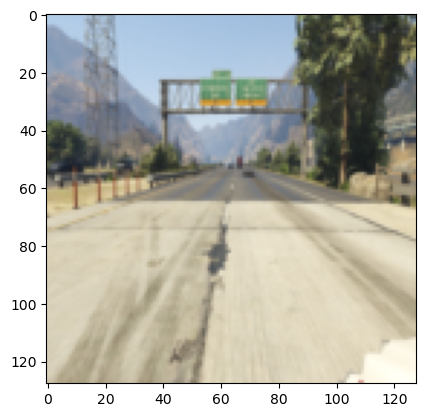

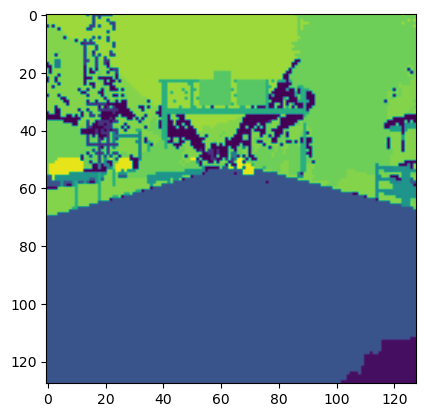

In [4]:
from torchvision.transforms import RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize
example_transform = Compose([Resize((128,128), antialias=True)])
example_dataset = DataLoaderSegmentation(train_path,example_transform)

img, label = example_dataset[30]

plt.figure(0)
plt.imshow(img/torch.max(img))
plt.figure(1)
plt.imshow(label)



Convert from RGB to LAB

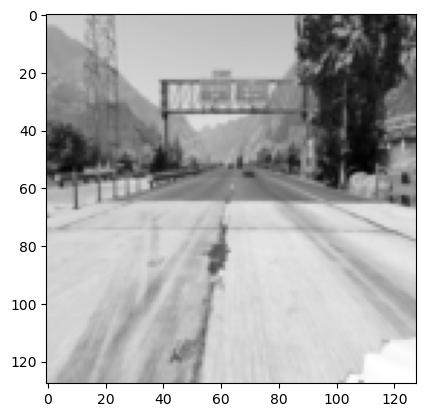

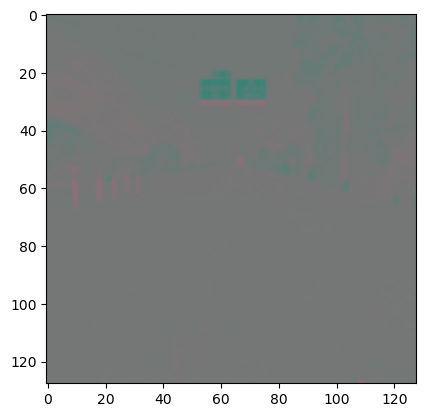

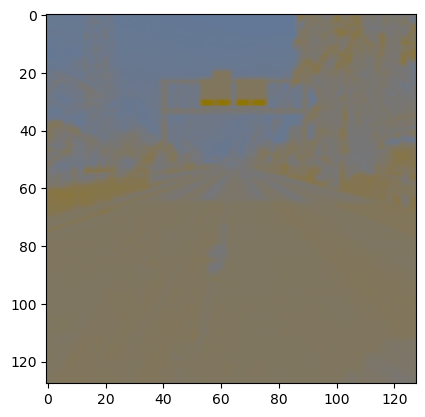

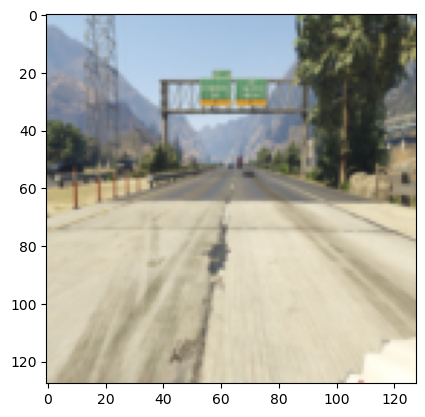

In [5]:
#!pip install kornia
from matplotlib.colors import LinearSegmentedColormap
import kornia

# L A B
# L - Lightness
# A - Red & Green
# B - Blue & Yellow

img_norm = img/255
img_lab = kornia.color.rgb_to_lab(img_norm.permute(2, 0, 1))

L = (img_lab.permute(1, 2, 0))[:,:,0]
A = (img_lab.permute(1, 2, 0))[:,:,1]
B = (img_lab.permute(1, 2, 0))[:,:,2]

Lfill = 50*torch.ones(L.shape)
Zfill = torch.zeros(L.shape)

Avis = kornia.color.lab_to_rgb(torch.stack((Lfill, A, Zfill),0)).permute(1, 2, 0)
Bvis = kornia.color.lab_to_rgb(torch.stack((Lfill, Zfill, B),0)).permute(1, 2, 0)

full_vis = kornia.color.lab_to_rgb(torch.stack((L, A, B),0)).permute(1, 2, 0)

plt.figure(0)
plt.imshow(L, "gray")
plt.figure(1)
plt.imshow(Avis)
plt.figure(2)
plt.imshow(Bvis)
plt.figure(3)
plt.imshow(full_vis)

Perform transforms on the images maybe

Create dataloaders

In [6]:
#example_transform = Compose([Resize((128,128), antialias=True)])
#example_dataset = DataLoaderSegmentation(train_path,example_transform)

train_transforms = Compose([Resize((128,128), antialias=True)])

train_set = DataLoaderSegmentation(train_path, train_transforms)
val_set = DataLoaderSegmentation(val_path, train_transforms)

batch_size = 16
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Build the model class

In [7]:
# Source
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

Build the training loop

In [16]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        # Validate fucks up
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):    
        inputs_, labels = x.to(device), y.to(device)
        
        inputs = inputs_.permute(0,3,1,2)

        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        
        #hard_preds = output_to_label(z)
        #acc_batch_avg = (hard_preds == labels).float().mean().item()
        #train_acc_batches.append(acc_batch_avg)

        print("Thinking.... ", batch_index)
        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            print(batch_index)
            inputs_, labels = x.to(device), y.to(device)
            inputs = inputs_.permute(0,3,1,2)
            z_ = model.forward(inputs)
            z = torch.squeeze(z_)
            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()      
            
            # Visual test
            if batch_index == 1:
                #print(z[0,:,:].shape)
                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(z[0,:,:])
                axarr[1].imshow(labels.float()[0,:,:])
                #plt.imshow(z[0,:,:])
                plt.show()
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)


Text

Starting training
Thinking....  1
1


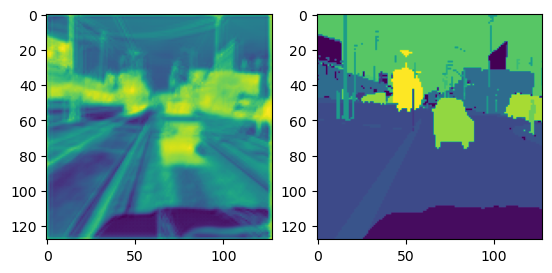

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 1/125: 	Train loss: 191.405, 	Train acc.: 0.000, 	Val. loss: 201.080, 	Val. acc.: 0.000
Thinking....  2
1


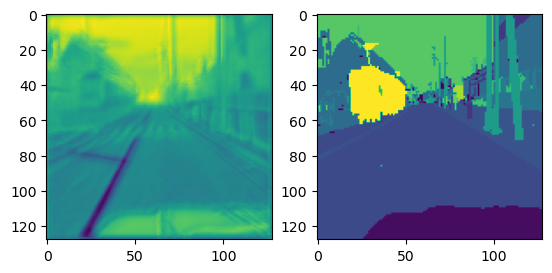

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 2/125: 	Train loss: 183.669, 	Train acc.: 0.000, 	Val. loss: 183.543, 	Val. acc.: 0.000
Thinking....  3
1


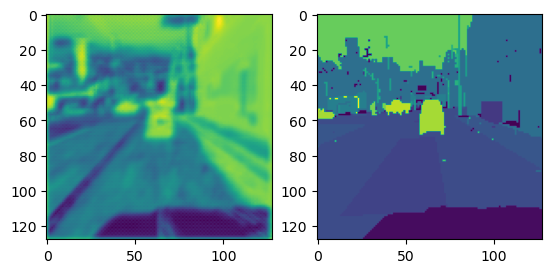

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 3/125: 	Train loss: 186.692, 	Train acc.: 0.000, 	Val. loss: 204.961, 	Val. acc.: 0.000
Thinking....  4
1


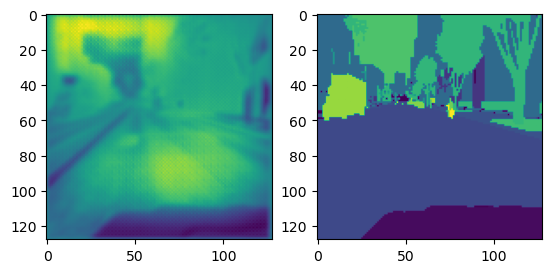

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 4/125: 	Train loss: 170.345, 	Train acc.: 0.000, 	Val. loss: 166.641, 	Val. acc.: 0.000
Thinking....  5
1


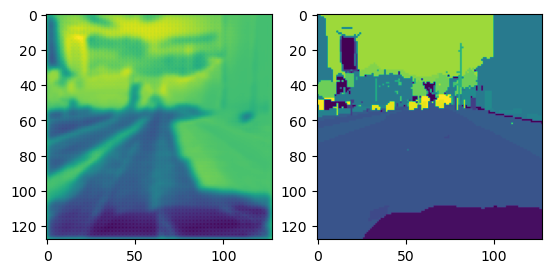

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 5/125: 	Train loss: 178.866, 	Train acc.: 0.000, 	Val. loss: 203.604, 	Val. acc.: 0.000
Thinking....  6
1


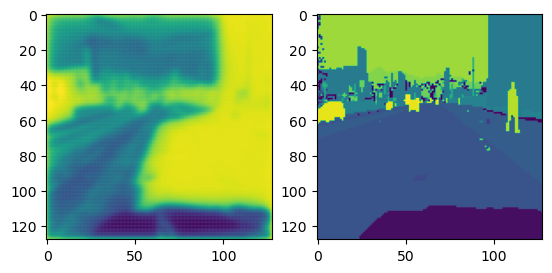

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 6/125: 	Train loss: 157.471, 	Train acc.: 0.000, 	Val. loss: 290.883, 	Val. acc.: 0.000
Thinking....  7
1


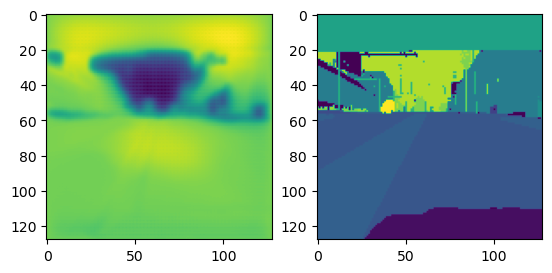

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 7/125: 	Train loss: 154.296, 	Train acc.: 0.000, 	Val. loss: 233.967, 	Val. acc.: 0.000
Thinking....  8
1


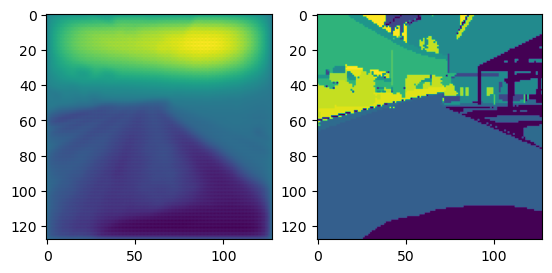

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 8/125: 	Train loss: 196.714, 	Train acc.: 0.000, 	Val. loss: 169.854, 	Val. acc.: 0.000
Thinking....  9
1


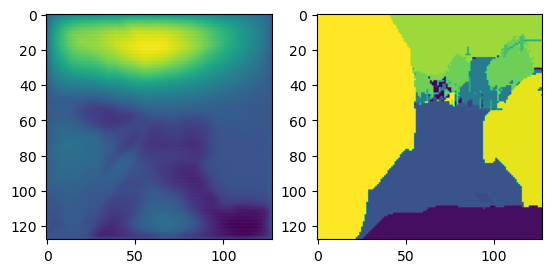

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 9/125: 	Train loss: 169.507, 	Train acc.: 0.000, 	Val. loss: 206.349, 	Val. acc.: 0.000
Thinking....  10
1


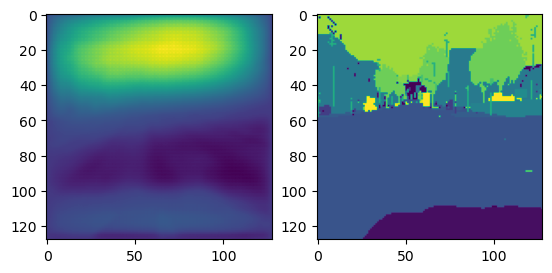

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 10/125: 	Train loss: 164.064, 	Train acc.: 0.000, 	Val. loss: 406.077, 	Val. acc.: 0.000
Thinking....  11
1


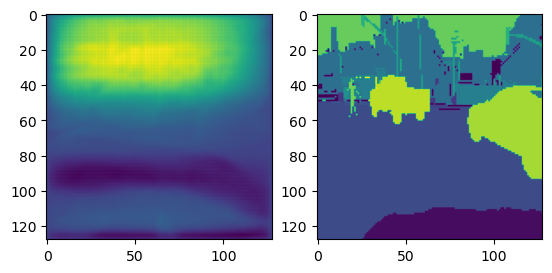

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 11/125: 	Train loss: 177.621, 	Train acc.: 0.000, 	Val. loss: 289.246, 	Val. acc.: 0.000
Thinking....  12
1


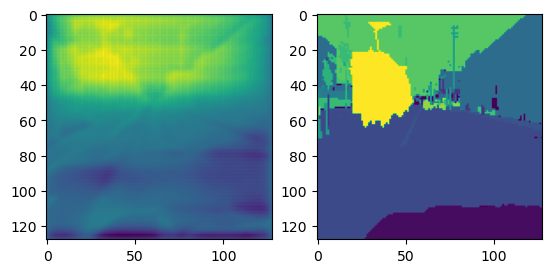

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 12/125: 	Train loss: 153.892, 	Train acc.: 0.000, 	Val. loss: 99.194, 	Val. acc.: 0.000
Thinking....  13
1


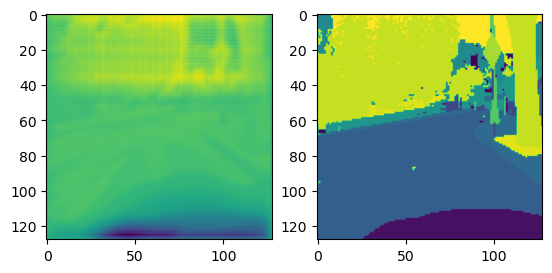

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 13/125: 	Train loss: 154.403, 	Train acc.: 0.000, 	Val. loss: 170.496, 	Val. acc.: 0.000
Thinking....  14
1


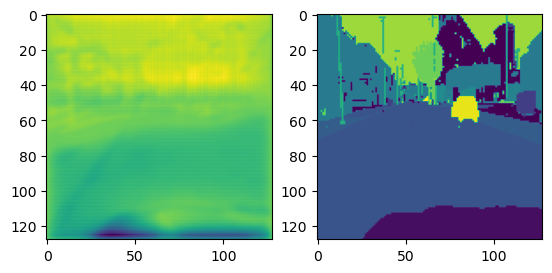

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 14/125: 	Train loss: 172.813, 	Train acc.: 0.000, 	Val. loss: 185.570, 	Val. acc.: 0.000
Thinking....  15
1


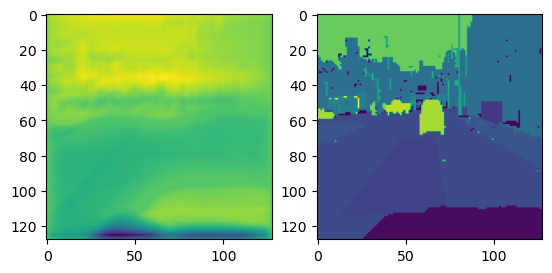

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 15/125: 	Train loss: 142.846, 	Train acc.: 0.000, 	Val. loss: 148.269, 	Val. acc.: 0.000
Thinking....  16
1


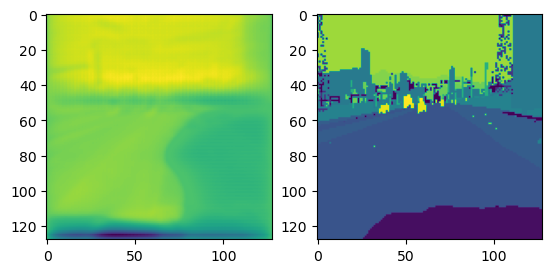

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 16/125: 	Train loss: 149.542, 	Train acc.: 0.000, 	Val. loss: 128.988, 	Val. acc.: 0.000
Thinking....  17
1


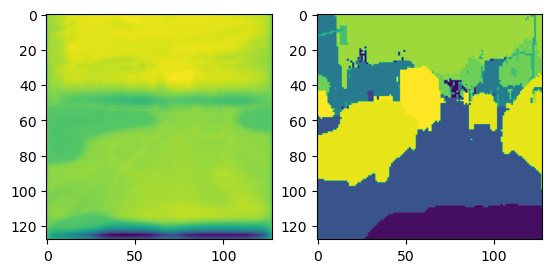

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 17/125: 	Train loss: 165.023, 	Train acc.: 0.000, 	Val. loss: 127.211, 	Val. acc.: 0.000
Thinking....  18
1


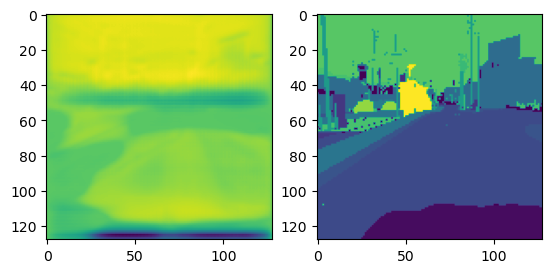

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 18/125: 	Train loss: 160.373, 	Train acc.: 0.000, 	Val. loss: 137.989, 	Val. acc.: 0.000
Thinking....  19
1


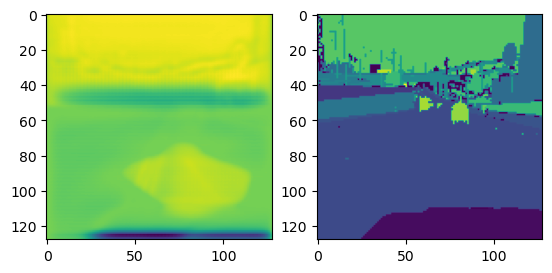

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 19/125: 	Train loss: 170.617, 	Train acc.: 0.000, 	Val. loss: 160.941, 	Val. acc.: 0.000
Thinking....  20
1


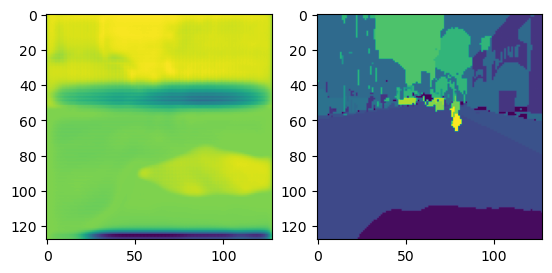

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 20/125: 	Train loss: 143.426, 	Train acc.: 0.000, 	Val. loss: 182.481, 	Val. acc.: 0.000
Thinking....  21
1


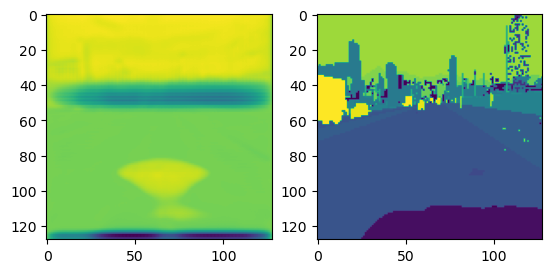

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 21/125: 	Train loss: 162.368, 	Train acc.: 0.000, 	Val. loss: 205.378, 	Val. acc.: 0.000
Thinking....  22
1


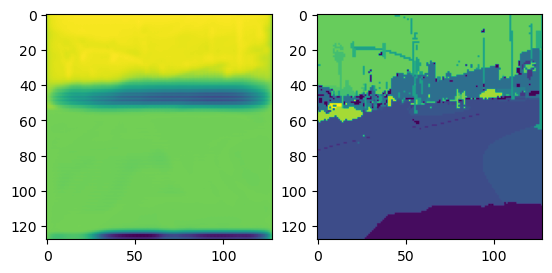

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 22/125: 	Train loss: 176.050, 	Train acc.: 0.000, 	Val. loss: 226.849, 	Val. acc.: 0.000
Thinking....  23
1


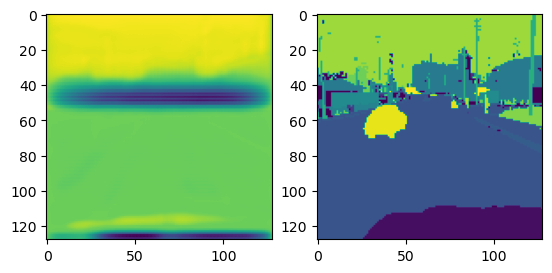

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 23/125: 	Train loss: 159.209, 	Train acc.: 0.000, 	Val. loss: 251.363, 	Val. acc.: 0.000
Thinking....  24
1


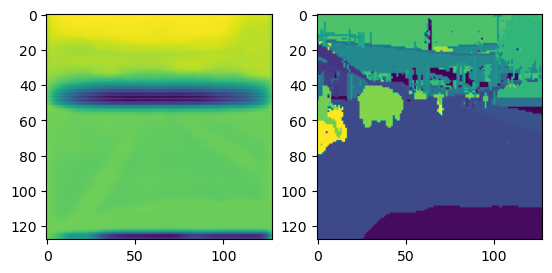

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 24/125: 	Train loss: 142.019, 	Train acc.: 0.000, 	Val. loss: 251.478, 	Val. acc.: 0.000
Thinking....  25
1


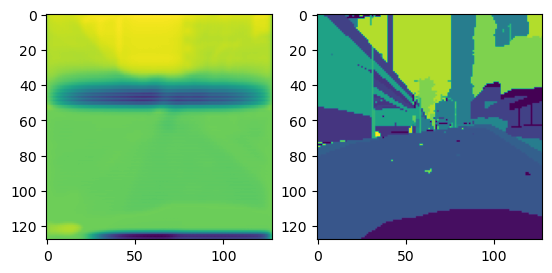

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 25/125: 	Train loss: 136.663, 	Train acc.: 0.000, 	Val. loss: 238.694, 	Val. acc.: 0.000
Thinking....  26
1


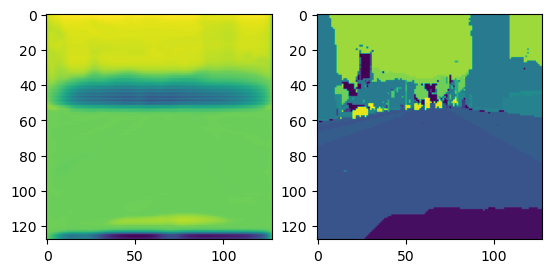

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 26/125: 	Train loss: 151.941, 	Train acc.: 0.000, 	Val. loss: 221.624, 	Val. acc.: 0.000
Thinking....  27
1


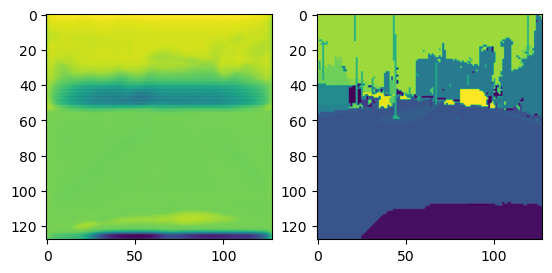

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 27/125: 	Train loss: 145.593, 	Train acc.: 0.000, 	Val. loss: 203.208, 	Val. acc.: 0.000
Thinking....  28
1


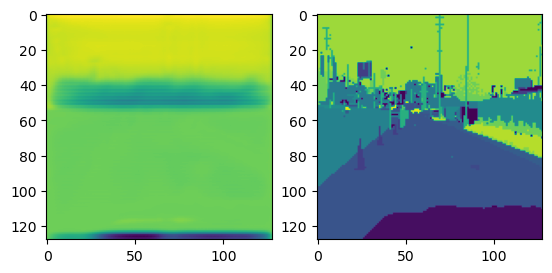

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 28/125: 	Train loss: 146.056, 	Train acc.: 0.000, 	Val. loss: 179.793, 	Val. acc.: 0.000
Thinking....  29
1


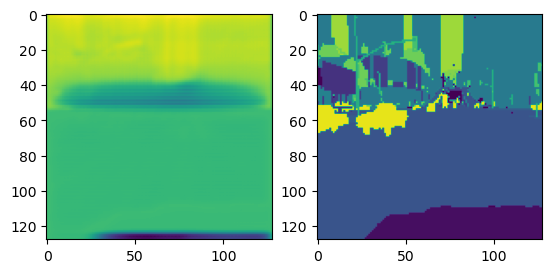

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 29/125: 	Train loss: 142.920, 	Train acc.: 0.000, 	Val. loss: 157.472, 	Val. acc.: 0.000
Thinking....  30
1


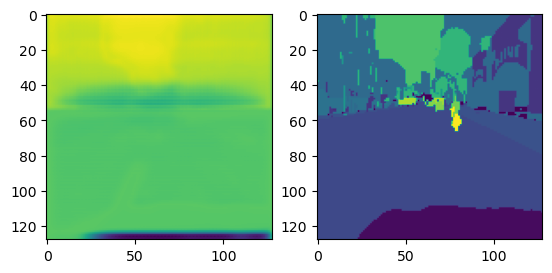

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 30/125: 	Train loss: 154.219, 	Train acc.: 0.000, 	Val. loss: 145.503, 	Val. acc.: 0.000
Thinking....  31
1


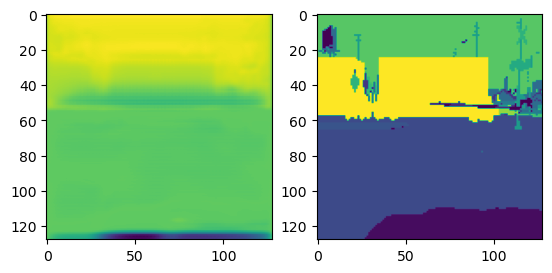

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 31/125: 	Train loss: 133.137, 	Train acc.: 0.000, 	Val. loss: 137.950, 	Val. acc.: 0.000
Thinking....  32
1


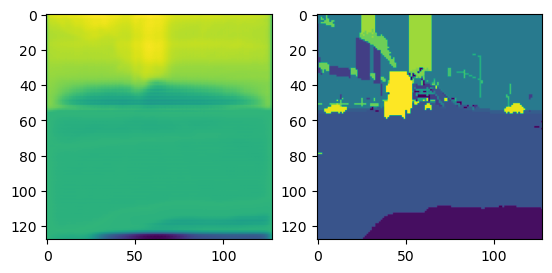

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 32/125: 	Train loss: 154.082, 	Train acc.: 0.000, 	Val. loss: 137.879, 	Val. acc.: 0.000
Thinking....  33
1


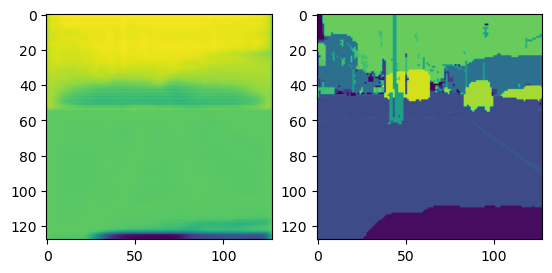

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 33/125: 	Train loss: 153.744, 	Train acc.: 0.000, 	Val. loss: 141.046, 	Val. acc.: 0.000
Thinking....  34
1


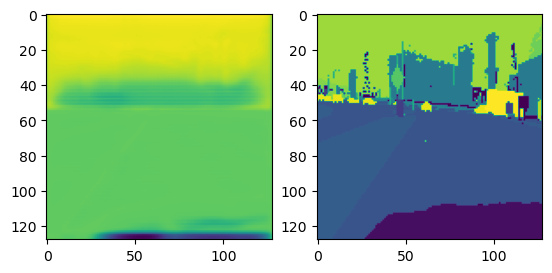

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 34/125: 	Train loss: 144.409, 	Train acc.: 0.000, 	Val. loss: 147.400, 	Val. acc.: 0.000
Thinking....  35
1


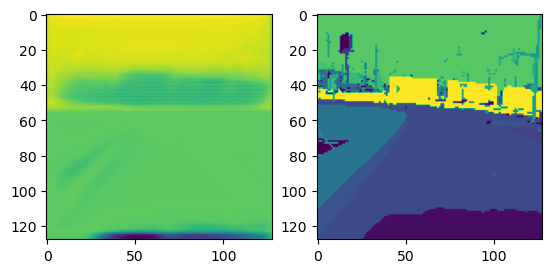

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 35/125: 	Train loss: 144.111, 	Train acc.: 0.000, 	Val. loss: 150.388, 	Val. acc.: 0.000
Thinking....  36
1


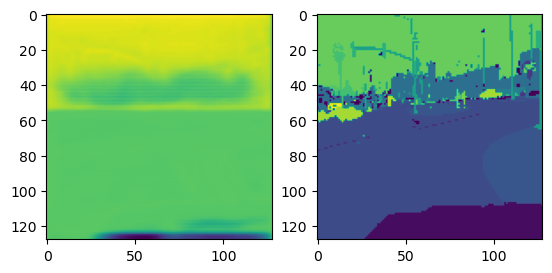

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 36/125: 	Train loss: 133.951, 	Train acc.: 0.000, 	Val. loss: 144.900, 	Val. acc.: 0.000
Thinking....  37
1


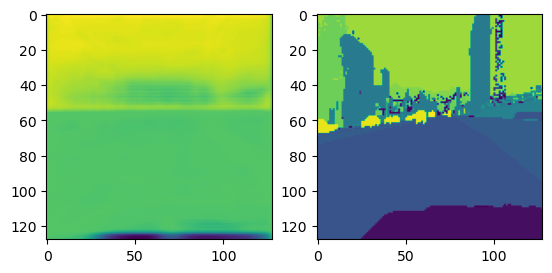

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 37/125: 	Train loss: 129.056, 	Train acc.: 0.000, 	Val. loss: 138.967, 	Val. acc.: 0.000
Thinking....  38
1


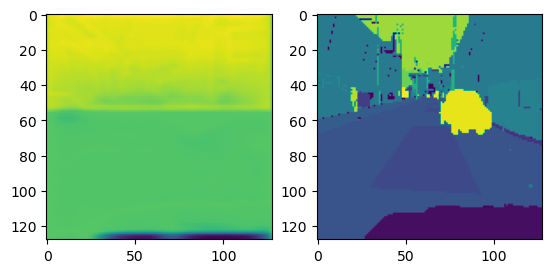

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 38/125: 	Train loss: 133.025, 	Train acc.: 0.000, 	Val. loss: 133.104, 	Val. acc.: 0.000
Thinking....  39
1


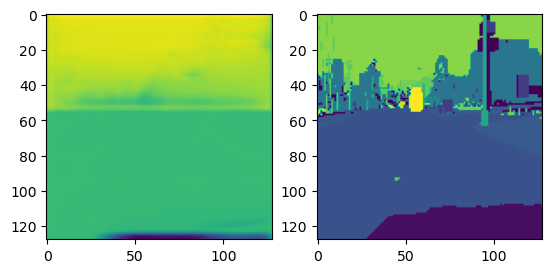

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 39/125: 	Train loss: 134.134, 	Train acc.: 0.000, 	Val. loss: 130.281, 	Val. acc.: 0.000
Thinking....  40
1


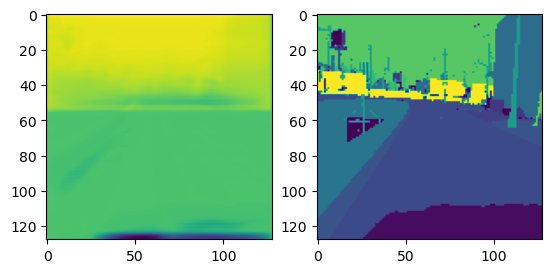

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 40/125: 	Train loss: 121.646, 	Train acc.: 0.000, 	Val. loss: 127.617, 	Val. acc.: 0.000
Thinking....  41
1


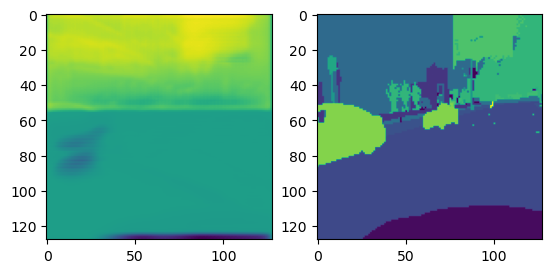

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 41/125: 	Train loss: 133.910, 	Train acc.: 0.000, 	Val. loss: 123.295, 	Val. acc.: 0.000
Thinking....  42
1


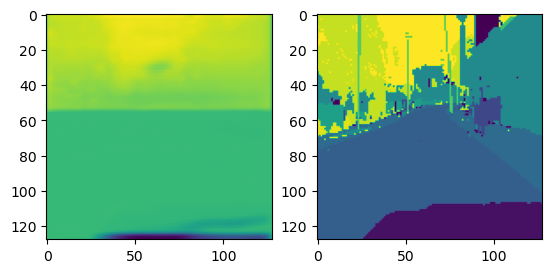

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 42/125: 	Train loss: 138.409, 	Train acc.: 0.000, 	Val. loss: 122.116, 	Val. acc.: 0.000
Thinking....  43
1


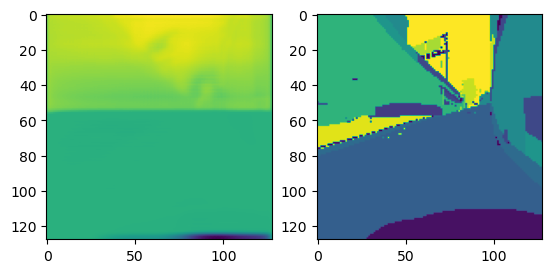

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 43/125: 	Train loss: 133.612, 	Train acc.: 0.000, 	Val. loss: 119.769, 	Val. acc.: 0.000
Thinking....  44
1


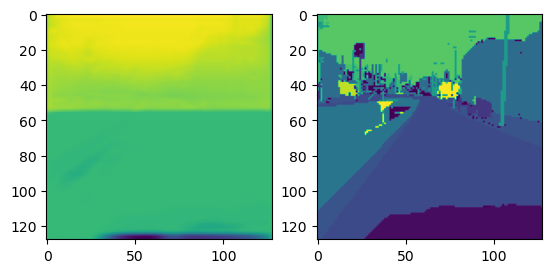

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 44/125: 	Train loss: 127.154, 	Train acc.: 0.000, 	Val. loss: 118.747, 	Val. acc.: 0.000
Thinking....  45
1


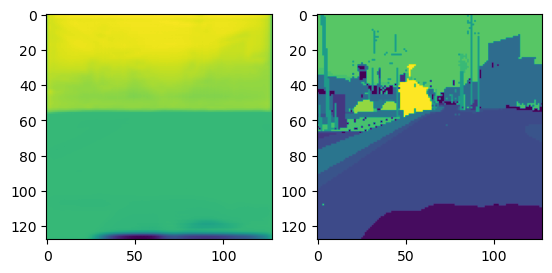

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 45/125: 	Train loss: 127.394, 	Train acc.: 0.000, 	Val. loss: 117.696, 	Val. acc.: 0.000
Thinking....  46
1


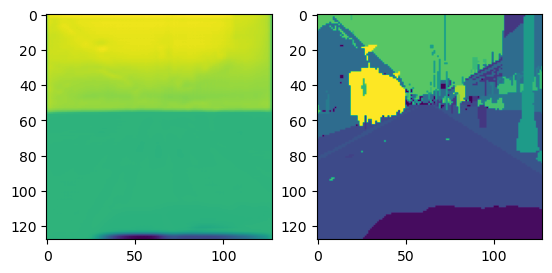

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 46/125: 	Train loss: 144.952, 	Train acc.: 0.000, 	Val. loss: 117.955, 	Val. acc.: 0.000
Thinking....  47
1


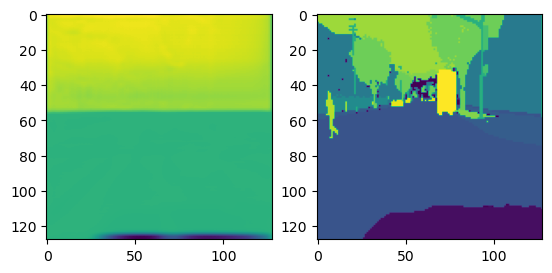

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 47/125: 	Train loss: 146.417, 	Train acc.: 0.000, 	Val. loss: 118.631, 	Val. acc.: 0.000
Thinking....  48
1


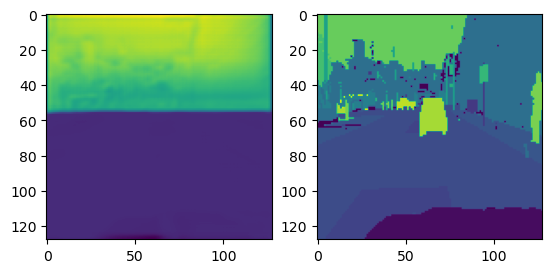

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 48/125: 	Train loss: 123.241, 	Train acc.: 0.000, 	Val. loss: 116.967, 	Val. acc.: 0.000
Thinking....  49
1


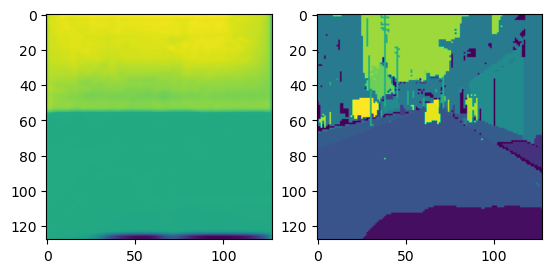

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 49/125: 	Train loss: 131.223, 	Train acc.: 0.000, 	Val. loss: 113.562, 	Val. acc.: 0.000
Thinking....  50
1


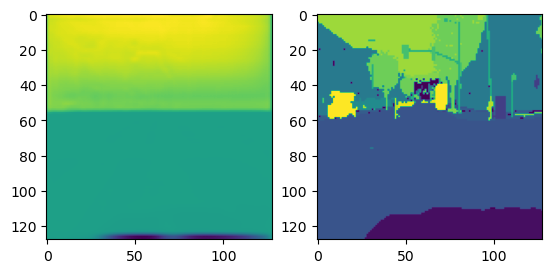

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 50/125: 	Train loss: 119.232, 	Train acc.: 0.000, 	Val. loss: 110.579, 	Val. acc.: 0.000
Thinking....  51
1


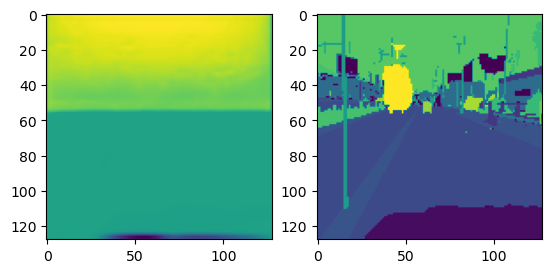

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 51/125: 	Train loss: 130.327, 	Train acc.: 0.000, 	Val. loss: 108.361, 	Val. acc.: 0.000
Thinking....  52
1


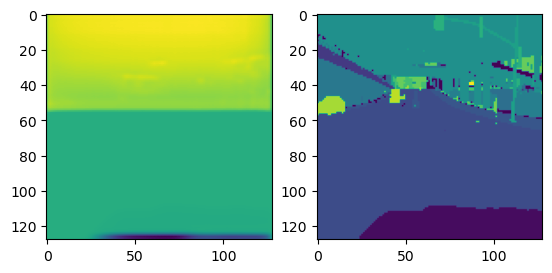

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 52/125: 	Train loss: 127.331, 	Train acc.: 0.000, 	Val. loss: 108.857, 	Val. acc.: 0.000
Thinking....  53
1


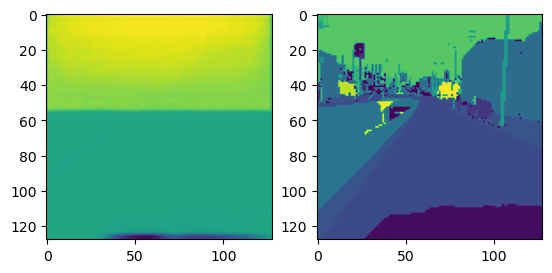

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 53/125: 	Train loss: 143.902, 	Train acc.: 0.000, 	Val. loss: 111.753, 	Val. acc.: 0.000
Thinking....  54
1


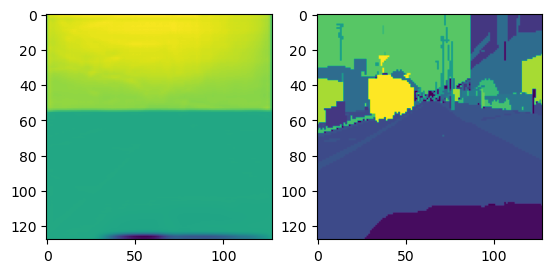

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 54/125: 	Train loss: 120.929, 	Train acc.: 0.000, 	Val. loss: 113.050, 	Val. acc.: 0.000
Thinking....  55
1


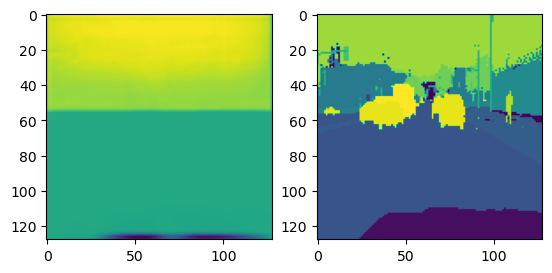

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 55/125: 	Train loss: 142.710, 	Train acc.: 0.000, 	Val. loss: 112.838, 	Val. acc.: 0.000
Thinking....  56
1


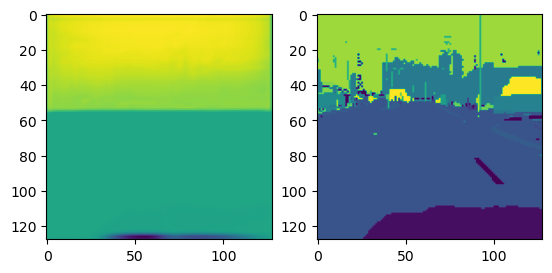

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 56/125: 	Train loss: 126.169, 	Train acc.: 0.000, 	Val. loss: 112.114, 	Val. acc.: 0.000
Thinking....  57
1


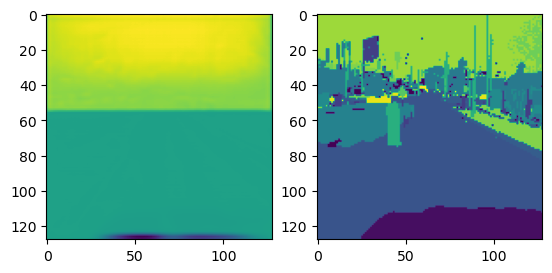

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 57/125: 	Train loss: 121.319, 	Train acc.: 0.000, 	Val. loss: 111.223, 	Val. acc.: 0.000
Thinking....  58
1


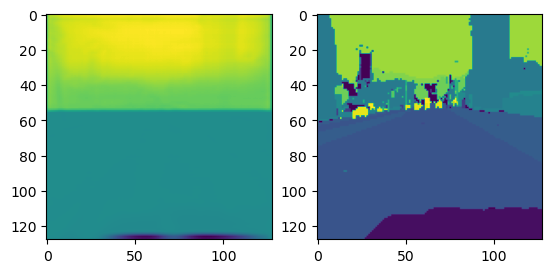

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 58/125: 	Train loss: 130.784, 	Train acc.: 0.000, 	Val. loss: 109.495, 	Val. acc.: 0.000
Thinking....  59
1


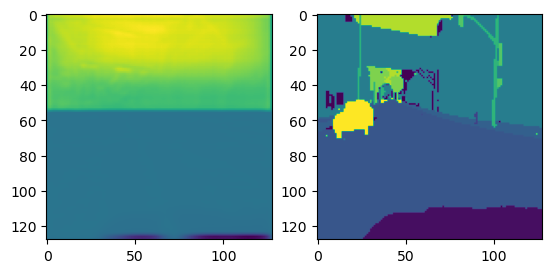

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 59/125: 	Train loss: 123.098, 	Train acc.: 0.000, 	Val. loss: 107.309, 	Val. acc.: 0.000
Thinking....  60
1


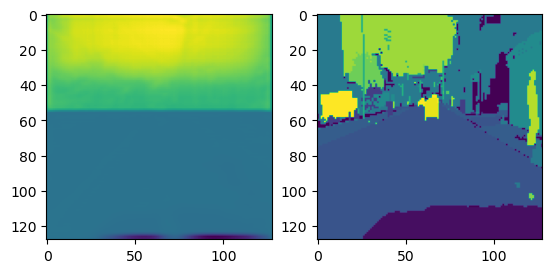

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 60/125: 	Train loss: 116.533, 	Train acc.: 0.000, 	Val. loss: 107.247, 	Val. acc.: 0.000
Thinking....  61
1


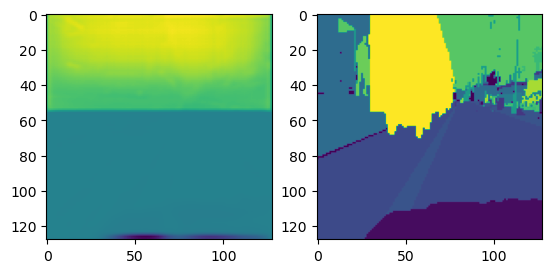

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 61/125: 	Train loss: 110.390, 	Train acc.: 0.000, 	Val. loss: 109.531, 	Val. acc.: 0.000
Thinking....  62
1


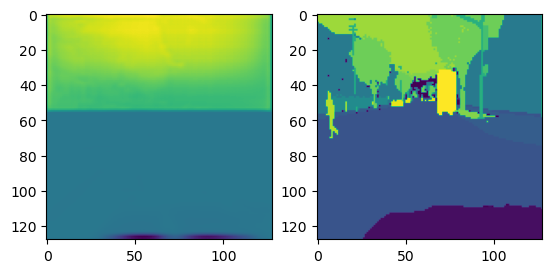

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 62/125: 	Train loss: 117.859, 	Train acc.: 0.000, 	Val. loss: 112.371, 	Val. acc.: 0.000
Thinking....  63
1


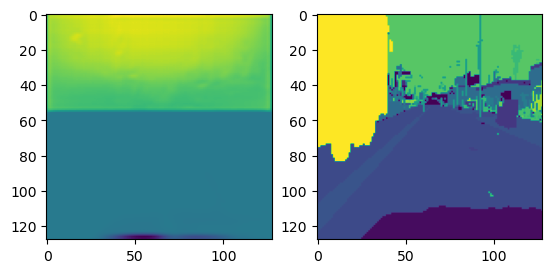

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 63/125: 	Train loss: 122.173, 	Train acc.: 0.000, 	Val. loss: 112.360, 	Val. acc.: 0.000
Thinking....  64
1


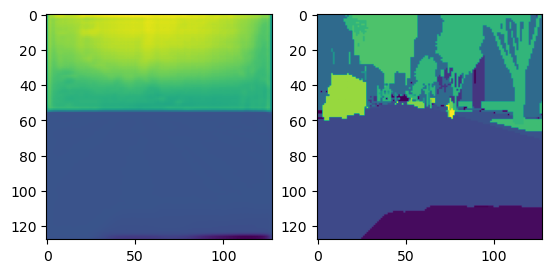

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 64/125: 	Train loss: 121.306, 	Train acc.: 0.000, 	Val. loss: 113.161, 	Val. acc.: 0.000
Thinking....  65
1


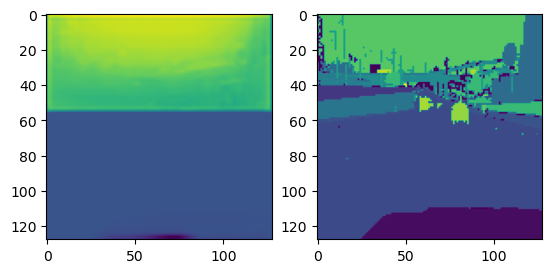

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 65/125: 	Train loss: 126.929, 	Train acc.: 0.000, 	Val. loss: 114.714, 	Val. acc.: 0.000
Thinking....  66
1


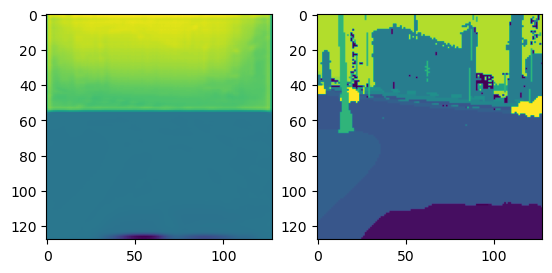

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 66/125: 	Train loss: 134.597, 	Train acc.: 0.000, 	Val. loss: 114.583, 	Val. acc.: 0.000
Thinking....  67
1


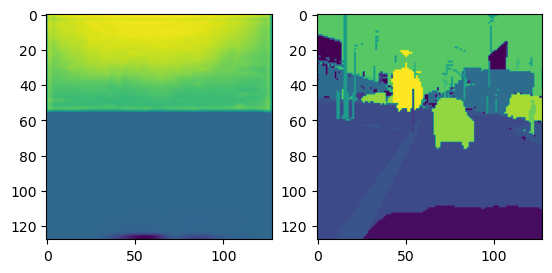

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 67/125: 	Train loss: 125.811, 	Train acc.: 0.000, 	Val. loss: 110.627, 	Val. acc.: 0.000
Thinking....  68
1


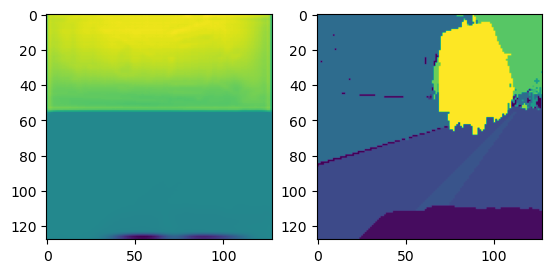

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 68/125: 	Train loss: 124.250, 	Train acc.: 0.000, 	Val. loss: 106.853, 	Val. acc.: 0.000
Thinking....  69
1


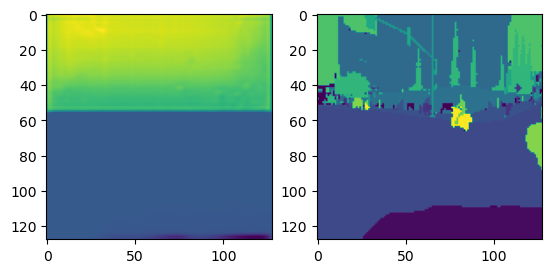

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 69/125: 	Train loss: 133.764, 	Train acc.: 0.000, 	Val. loss: 107.700, 	Val. acc.: 0.000
Thinking....  70
1


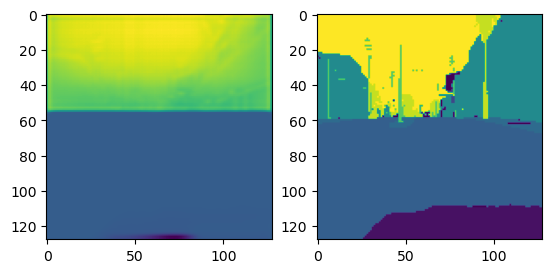

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 70/125: 	Train loss: 134.808, 	Train acc.: 0.000, 	Val. loss: 107.944, 	Val. acc.: 0.000
Thinking....  71
1


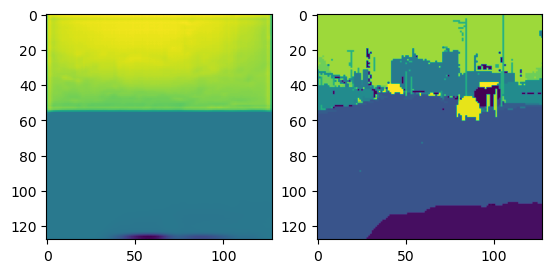

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 71/125: 	Train loss: 102.273, 	Train acc.: 0.000, 	Val. loss: 109.491, 	Val. acc.: 0.000
Thinking....  72
1


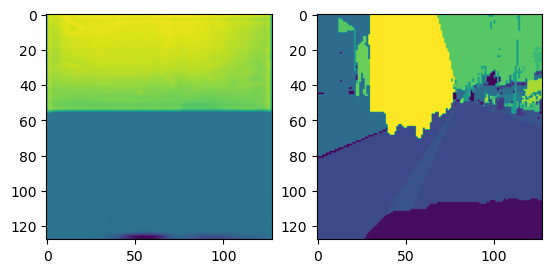

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
	Batch 72/125: 	Train loss: 98.139, 	Train acc.: 0.000, 	Val. loss: 109.283, 	Val. acc.: 0.000
Thinking....  73
1


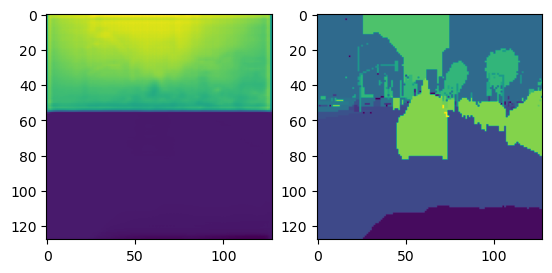

2
3
4
5
6
7
8
9
10
11
12


In [ ]:
Segmentaion_model = build_unet()

optimizer = optim.Adam(Segmentaion_model.parameters(), lr =0.001)
loss_fn = nn.MSELoss()
train_loader = train_dataloader 
val_loader = val_dataloader
num_epochs = 1
print_every = 1

Segmentaion_model, Segmentaion_train_losses, Segmentaion_train_accs, Segmentaion_val_losses, Segmentaion_val_accs= training_loop(Segmentaion_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)



Text

Text